In [122]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')

In [3]:
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_data['Location'])
train_data['Location'] = le.transform(train_data['Location'])
test_data['Location'] = le.transform(test_data['Location'])

In [5]:
X_train = train_data.drop(["Id", "Next Week's Deaths"], axis=1)
y_train = train_data["Next Week's Deaths"]
X_test = test_data.drop(["Id"], axis=1)

In [96]:
import lightgbm as lgb

data_train = lgb.Dataset(X_train, y_train)

# max_depth is not used
params = {
    'objective': 'regression',
    'learning_rate': 0.1,
    'num_leaves': 50,   # lightGBM is leave_wise tree model，so number of leaves should be small than 2^max_depth
    'subsample': 1,   # sample of data
    'feature_fraction': 1,   # sample of feature
    'seed': 42,
    'verbosity': -1,
}

cv_result = lgb.cv(params, data_train, num_boost_round=1000, nfold=5, stratified=False, shuffle=True,
                   metrics='rmse', early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0)

# The result shows that it does not converge with 1000 boosting iteration. 
# But considering about time and memory, choose 1000 here.

[50]	cv_agg's rmse: 408.445 + 29.1948
[100]	cv_agg's rmse: 358.882 + 29.2779
[150]	cv_agg's rmse: 338.135 + 30.0248
[200]	cv_agg's rmse: 325.559 + 29.6262
[250]	cv_agg's rmse: 315.605 + 30.152
[300]	cv_agg's rmse: 307.451 + 30.3748
[350]	cv_agg's rmse: 300.934 + 30.0661
[400]	cv_agg's rmse: 296.179 + 30.0125
[450]	cv_agg's rmse: 292.438 + 30.1155
[500]	cv_agg's rmse: 289.258 + 30.1833
[550]	cv_agg's rmse: 286.045 + 30.0518
[600]	cv_agg's rmse: 283.401 + 30.1052
[650]	cv_agg's rmse: 281.281 + 30.2811
[700]	cv_agg's rmse: 279.744 + 30.0997
[750]	cv_agg's rmse: 278.178 + 30.0129
[800]	cv_agg's rmse: 277.095 + 29.9002
[850]	cv_agg's rmse: 276.233 + 29.8006
[900]	cv_agg's rmse: 275.108 + 29.7837
[950]	cv_agg's rmse: 274.41 + 29.8175
[1000]	cv_agg's rmse: 273.563 + 29.7334


In [136]:
X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = \
                    train_test_split(X_train, y_train, test_size=0.3)

dtrain = lgb.Dataset(X_train_lgb, y_train_lgb)
dvalid = lgb.Dataset(X_valid_lgb, y_valid_lgb)

params = {
    'objective': 'regression',
    'learning_rate': 0.1,
    'num_leaves': 50,  
    'subsample': 1,   
    'feature_fraction': 1,   
    'seed': 42,
    'verbosity': -1,
    'metric': 'rmse',
}


model1 = lgb.train(params, train_set=dtrain, valid_sets=dvalid, num_boost_round=1000,
                   early_stopping_rounds=50, verbose_eval=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 449.539
[100]	valid_0's rmse: 397.33
[150]	valid_0's rmse: 377.473
[200]	valid_0's rmse: 364.181
[250]	valid_0's rmse: 353.053
[300]	valid_0's rmse: 344.941
[350]	valid_0's rmse: 339.115
[400]	valid_0's rmse: 333.615
[450]	valid_0's rmse: 329.809
[500]	valid_0's rmse: 326.332
[550]	valid_0's rmse: 324.152
[600]	valid_0's rmse: 321.45
[650]	valid_0's rmse: 319.938
[700]	valid_0's rmse: 318.579
[750]	valid_0's rmse: 316.858
[800]	valid_0's rmse: 315.4
[850]	valid_0's rmse: 314.164
[900]	valid_0's rmse: 313.042
[950]	valid_0's rmse: 312.207
[1000]	valid_0's rmse: 311.746
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 311.746


In [138]:
y_pred = model1.predict(X_test)
y_pred = y_pred.astype(int)
y_pred = np.where(y_pred < 0, 0, y_pred) 
output = pd.DataFrame({"Id": test_data.Id, "Next Week's Deaths": y_pred})
output.to_csv('output/lightgbm_05.csv', index=False)   # RMSE score: 324.7

In [75]:
import matplotlib.pyplot as plt

# test the best learning rate when num_boost_round = 1000
  
axisx = np.arange(0.1, 0.25, 0.02)
rmse_mean = []
rmse_std = []
for i in axisx:

    data_train = lgb.Dataset(X_train, y_train)

    params = {
        'objective': 'regression',
        'learning_rate': i,
        'num_leaves': 50,   
        'subsample': 1,   
        'feature_fraction': 1,  
        'seed': 42,
        'verbosity': -1,
    }

    cv_result = lgb.cv(params, data_train, num_boost_round=1000, nfold=5, stratified=False, shuffle=True,
                   metrics='rmse', early_stopping_rounds=50, verbose_eval=False, show_stdv=True, seed=0)
    rmse_mean.append(cv_result['rmse-mean'][-1])
    rmse_std.append(cv_result['rmse-stdv'][-1])

In [80]:
# plot the learning curve 
def plot_figure(axisx, rmse_mean, rmse_std, feature):
    rmse_mean = np.array(rmse_mean)
    rmse_std = np.array(rmse_std)
    plt.figure(figsize=(20, 5))
    plt.plot(axisx, rmse_mean, c='black', marker='o',label=feature)
    plt.plot(axisx, rmse_mean+rmse_std, c='red', marker='o', linestyle='-.')
    plt.plot(axisx, rmse_mean-rmse_std, c='red', marker='o', linestyle='-.')
    plt.legend()
    plt.show()

The best param of learning rate 0.16000000000000003


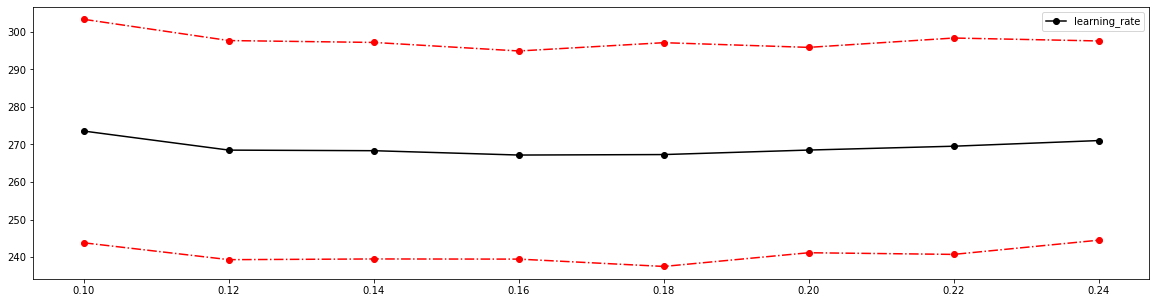

In [94]:
print('The best param of learning rate', axisx[np.argmin(rmse_mean)])
plot_figure(axisx, rmse_mean, rmse_std, 'learning_rate')

# Result shows the best learning rate is 0.16

In [120]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None):
    train_size, train_scores, test_scores = learning_curve(estimator, X, y, shuffle=True, cv=cv, n_jobs=n_jobs)
   
    # plot the learning curve
    #ax = plt.figure()
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.plot(train_size, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
    ax.plot(train_size, np.mean(test_scores, axis=1), 'o-', color='g', label='Test score')
    ax.legend(loc='best')
    return ax      

In [ ]:
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# estimator = lgb.LGBMRegressor(n_estimators=100, num_leaves=50, learning_rate=0.16, metrics='rmse',
#                              subsample=1, feature_fraction=1, seed=42, verbose=-1, silent=True)
# plot_learning_curve(estimator, "LGBM", X_train, y_train, cv=cv)
# plt.show()

In [114]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
estimator = lgb.LGBMRegressor(n_estimators=1000, num_leaves=50, learning_rate=0.16, metrics='rmse',
                             subsample=1, feature_fraction=1, seed=42, verbose=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X_train, y_train, 
                                                       shuffle=True, cv=cv, n_jobs=-1)

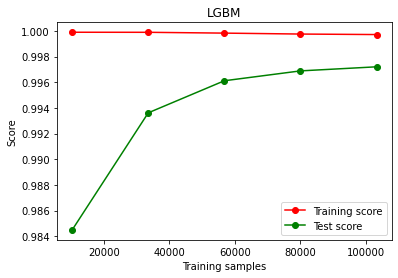

In [124]:
plt.figure()
plt.title("LGBM")
plt.xlabel("Training samples")
plt.ylabel("Score")
plt.plot(train_size, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_size, np.mean(test_scores, axis=1), 'o-', color='g', label='Test score')
plt.legend(loc='best')
plt.show()

# model is not overfitted

In [148]:
# test for feature fraction
    
axisx = np.arange(0.1, 1.1, 0.1)
rmse_mean = []
rmse_std = []
for i in axisx:

    data_train = lgb.Dataset(X_train, y_train)

    params = {
        'objective': 'regression',
        'learning_rate': 0.16,
        'num_leaves': 50,   
        'subsample': 1,   
        'feature_fraction': i,  
        'seed': 42,
        'verbosity': -1,
    }

    cv_result = lgb.cv(params, data_train, num_boost_round=1000, nfold=5, stratified=False, shuffle=True,
                   metrics='rmse', early_stopping_rounds=50, verbose_eval=False, show_stdv=True, seed=0)
    rmse_mean.append(cv_result['rmse-mean'][-1])
    rmse_std.append(cv_result['rmse-stdv'][-1])

The best param of feature fraction 0.8


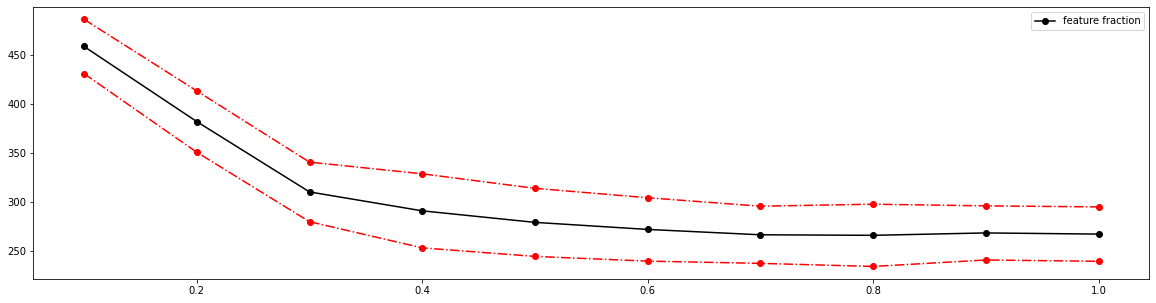

In [150]:
print('The best param of feature fraction', axisx[np.argmin(rmse_mean)])
plot_figure(axisx, rmse_mean, rmse_std, 'feature fraction')

# Result shows the best feature fraction is 0.8

In [151]:
# test for num leaves
# It took about 26 mins, I won't do it anymore. Too long.....
    
axisx = np.arange(20, 256, 20)
rmse_mean = []
rmse_std = []
for i in axisx:

    data_train = lgb.Dataset(X_train, y_train)

    params = {
        'objective': 'regression',
        'learning_rate': 0.16,
        'num_leaves': i,   
        'subsample': 1,   
        'feature_fraction': 0.8,  
        'seed': 42,
        'verbosity': -1,
    }

    cv_result = lgb.cv(params, data_train, num_boost_round=1000, nfold=5, stratified=False, shuffle=True,
                   metrics='rmse', early_stopping_rounds=50, verbose_eval=False, show_stdv=True, seed=0)
    rmse_mean.append(cv_result['rmse-mean'][-1])
    rmse_std.append(cv_result['rmse-stdv'][-1])

The best param of num leaves 60


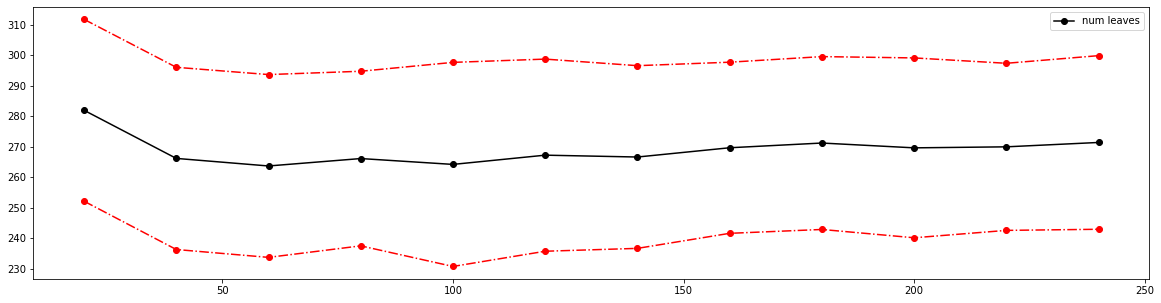

In [152]:
print('The best param of num leaves', axisx[np.argmin(rmse_mean)])
plot_figure(axisx, rmse_mean, rmse_std, 'num leaves')

# Result shows the best num leaves is 60

In [158]:
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# hyperparamter tuning with optuna
# tune num_leaves and max_depth first
def objective(trial):
    
    X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = \
                    train_test_split(X_train, y_train, test_size=0.3)

    dtrain = lgb.Dataset(X_train_lgb, y_train_lgb)
    dvalid = lgb.Dataset(X_valid_lgb, y_valid_lgb)

    param_grid ={
        "learning_rate": trial.suggest_float("learning_rate", 0.14, 0.18, step=0.05),
        "num_leaves": trial.suggest_int("num_leaves", 40, 80, step=10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200, step=10),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9, step=0.05),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 0.9, step=0.05),
    }
    
    params = {
    'objective': 'regression',
    'seed': 42,
    'metric': 'rmse',
    'verbose': -1
    }
    
    
    params.update(**params, **param_grid)
    
    pruning_callback = LightGBMPruningCallback(trial, 'rmse')
    model = lgb.train(params, num_boost_round=1000, train_set=dtrain, valid_sets=dvalid, verbose_eval=False, 
                      callbacks=[pruning_callback],
                     )
    y_pred = model.predict(X_valid_lgb)
    error = mean_squared_error(y_pred, y_valid_lgb)
    
    return error 

In [ ]:
study = optuna.create_study(direction='minimize', study_name='LBGM Regressor')
study.optimize(objective, n_trials=50)

In [160]:
trial = study.best_trial
trial.params

{'learning_rate': 0.14,
 'num_leaves': 60,
 'min_data_in_leaf': 20,
 'lambda_l1': 0,
 'lambda_l2': 0,
 'subsample': 0.7,
 'feature_fraction': 0.7}

In [161]:
params = {
    'objective': 'regression',
    'seed': 42,
    'metric': 'rmse',
    'verbose': -1
    }
    

params.update(**params, **trial.params)

model2 = lgb.train(params, train_set=dtrain, valid_sets=dvalid, num_boost_round=1000,
                   early_stopping_rounds=50, verbose_eval=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 394.979
[100]	valid_0's rmse: 361.147
[150]	valid_0's rmse: 343.016
[200]	valid_0's rmse: 332.827
[250]	valid_0's rmse: 325.193
[300]	valid_0's rmse: 319.463
[350]	valid_0's rmse: 315.78
[400]	valid_0's rmse: 311.738
[450]	valid_0's rmse: 308.676
[500]	valid_0's rmse: 307.178
[550]	valid_0's rmse: 305.652
[600]	valid_0's rmse: 304.383
[650]	valid_0's rmse: 302.658
[700]	valid_0's rmse: 301.706
[750]	valid_0's rmse: 301.066
[800]	valid_0's rmse: 300.173
[850]	valid_0's rmse: 299.604
[900]	valid_0's rmse: 299.092
[950]	valid_0's rmse: 298.555
[1000]	valid_0's rmse: 297.898
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 297.898


In [162]:
y_pred = model2.predict(X_test)
y_pred = y_pred.astype(int)
y_pred = np.where(y_pred < 0, 0, y_pred) 
output = pd.DataFrame({"Id": test_data.Id, "Next Week's Deaths": y_pred})
output.to_csv('output/lightgbm_07.csv', index=False)   # RMSE score: 315.5

In [ ]:
# use LightBGM Tunner

import optuna.integration.lightgbm as lgbo

X_train_lgb, X_valid_lgb, y_train_lgb, y_valid_lgb = \
                train_test_split(X_train, y_train, test_size=0.3)

dtrain = lgbo.Dataset(X_train_lgb, y_train_lgb)
dvalid = lgbo.Dataset(X_valid_lgb, y_valid_lgb)



params = {
    'objective': 'regression',
    'seed': 42,
    'metric': 'rmse',
    'verbose': -1
    }
    


booster = lgbo.LightGBMTuner(params, train_set=dtrain, valid_sets=dvalid, num_boost_round=1000,
                   early_stopping_rounds=50, verbose_eval=50)
booster.run()
model3 = booster.get_best_booster()

In [165]:
model3.params

{'objective': 'regression',
 'seed': 42,
 'metric': 'rmse',
 'verbose': -1,
 'feature_pre_filter': False,
 'lambda_l1': 3.672160238001776e-06,
 'lambda_l2': 7.862517798716215e-05,
 'num_leaves': 31,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 0.833688950169478,
 'bagging_freq': 4,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 50}

In [166]:
y_pred = model3.predict(X_test)
y_pred = y_pred.astype(int)
y_pred = np.where(y_pred < 0, 0, y_pred) 
output = pd.DataFrame({"Id": test_data.Id, "Next Week's Deaths": y_pred})
output.to_csv('output/lightgbm_08.csv', index=False)   # RMSE score: 323.2